## Setup

In [ ]:
# Remove RAPIDS & TF families that cause dependency conflicts in Colab
!pip -q uninstall -y \
  cudf-cu12 numba cuml-cu12 cugraph-cu12 dask-cudf-cu12 dask-cuda rapids-dask-dependency \
  distributed-ucxx-cu12 ucx-py-cu12 rmm-cu12 cudf-cu12 cuvs-cu12 cupy-cuda12x raft-dask-cu12 nx-cugraph-cu12 \
  pylibcugraph-cu12 pylibraft-cu12 ucxx-cu12 \
  tensorflow tensorflow-text tensorflow-decision-forests tf-keras keras keras-hub tensorflow-hub \
  ddsp crepe || true

# Fresh packaging toolchain
!pip -q install -U pip setuptools wheel build jedi

In [ ]:
# Fresh NumPy/SciPy
!pip -q install --no-cache-dir --force-reinstall "numpy==2.1.3" "scipy==1.14.1"

# TensorFlow stack that works on Py3.12 and satisfies DDSP/TFP imports
!pip -q install -U "tensorflow==2.20.0" "tf-keras==2.20.0" "tensorflow-probability==0.25.0"

# Silence CPU runtimes warning if present
!pip -q uninstall -y jax-cuda12-plugin -q || true

# numba compatible with NumPy 2.1.x (needed by librosa/resampy/etc.)
!pip -q install -U "numba==0.62.0"

# Audio + utils
!pip -q install -U librosa soundfile absl-py

# JAX + ecosystem
!pip -q install -U "jax[cpu]>=0.4.28" "flax>=0.8.2" "optax>=0.2.2" chex orbax-checkpoint gin-config clu


# Install DDSP source without its pinned (outdated) requirements
!pip -q install --no-deps "git+https://github.com/magenta/ddsp@main#egg=ddsp"

# f0 extractor (replacement for CREPE)
!pip -q install -U torch torchcrepe

In [1]:
import os
os.environ.setdefault("TF_GPU_ALLOCATOR", "cuda_malloc_async")  # helps fragmentation

import tensorflow as tf
# Let TF allocate GPU memory gradually
for gpu in tf.config.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("Could not set memory growth:", e)

# Mixed precision halves activation memory on GPU
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

print("Policy:", mixed_precision.global_policy())

Policy: <DTypePolicy "mixed_float16">


In [2]:
# Provide a tiny 'crepe' module so ddsp.losses can import; we won't call it.
import sys, types
_crepe = types.ModuleType("crepe")
def _predict_stub(*args, **kwargs):
    raise RuntimeError("ddsp.losses tried to call crepe.predict; use torchcrepe for f0 instead.")
_crepe.predict = _predict_stub
sys.modules["crepe"] = _crepe

# Smoke test
import numpy as np, librosa, soundfile, torch, torchcrepe
import tensorflow_probability as tfp
import jax, flax, ddsp

print("numpy:", np.__version__)
print("TF / TFP:", tf.__version__, "/", tfp.__version__)
print("jax / flax:", jax.__version__, "/", flax.__version__)
print("ddsp:", ddsp.__version__)

numpy: 2.1.3
TF / TFP: 2.20.0 / 0.25.0
jax / flax: 0.8.0 / 0.12.0
ddsp: 3.7.0


In [3]:
#@title Mount & paths
from google.colab import drive
from pathlib import Path
import yaml, json, math, time

drive.mount('/content/drive', force_remount=True)

PROJECT_DIR = Path('/content/drive/MyDrive/ddsp-demucs')
CFG = yaml.safe_load(open(PROJECT_DIR / 'env' / 'config.yaml'))

TFRECORDS_DIR = Path(CFG['paths']['tfrecords_dir'])
EXP_DIR = Path(CFG['paths']['exp_dir']) / 'run_ddsp_001'
EXP_DIR.mkdir(parents=True, exist_ok=True)

print("TFRecords:", TFRECORDS_DIR)
print("Exp:", EXP_DIR)

Mounted at /content/drive
TFRecords: /content/drive/MyDrive/ddsp-demucs/data/tfrecords
Exp: /content/drive/MyDrive/ddsp-demucs/exp/run_ddsp_001


In [4]:
import glob, os
for p in glob.glob("/content/cache/**/*.lockfile", recursive=True):
    try: os.remove(p)
    except FileNotFoundError: pass


## Training

In [5]:
#@title Globals
# === Globals ===
SR            = 22050
AUDIO_SAMPLES = 88200           # 4 s
TPRIME        = 1000            # conditioning frames
FRAME_RATE    = TPRIME * SR / AUDIO_SAMPLES  # 250.0 fps
HOP_SAMPLES   = int(round(SR / FRAME_RATE))  # 88
N_HARMONICS   = 64
N_NOISE_BANDS = 65
NFFT = 1024
HOP  = int(round(SR / FRAME_RATE))

# Frame math from constants you already use:
# AUDIO_SAMPLES = 88200, TPRIME = 1000  (adjust if yours differ)
HOP_APPROX     = int(round(AUDIO_SAMPLES / TPRIME))  # ≈ 88
WINDOW_SIZE    = int(2 * HOP_APPROX)                 # 176 (even), hop_used = 88
assert WINDOW_SIZE > 0 and WINDOW_SIZE % 2 == 0



In [6]:
#@title Torhcrepe-backed f0
import numpy as np, torch, torchcrepe, tensorflow as tf, ddsp
torch.set_num_threads(1)

def _torchcrepe_f0_np(y_np, sr, hop_length, fmin, fmax, periodicity_thresh, _ignored=None):
    # normalize scalars
    sr  = int(sr); hop_length = int(hop_length)
    fmin = float(fmin); fmax = float(fmax); periodicity_thresh = float(periodicity_thresh)

    # audio → [1, T] float32
    y_np = np.asarray(y_np, dtype=np.float32).reshape(-1)
    x = torch.from_numpy(y_np[None, :])  # [1, T]

    with torch.no_grad():
        f0, pd = torchcrepe.predict(
            x, sr, hop_length, fmin, fmax,
            model='tiny',                 # ← hardcoded; avoids bytes entirely
            batch_size=1024, device='cpu', return_periodicity=True,
        )

    f0 = f0.squeeze(0).cpu().numpy()
    pd = pd.squeeze(0).cpu().numpy()
    f0[pd < periodicity_thresh] = 0.0
    return f0.astype(np.float32, copy=False)

def _f0_from_torchcrepe_tf(y_1d, fmin=90.0, fmax=600.0,
                           hop_length=512, periodicity_thresh=0.40):
    f0 = tf.numpy_function(
        _torchcrepe_f0_np,
        [y_1d,
         tf.constant(SR, tf.int32),
         tf.constant(hop_length, tf.int32),
         tf.constant(fmin, tf.float32),
         tf.constant(fmax, tf.float32),
         tf.constant(periodicity_thresh, tf.float32),
         0],  # dummy
        Tout=tf.float32,
    )
    f0 = tf.reshape(f0, [-1])
    f0 = ddsp.core.resample(f0[tf.newaxis, :], TPRIME)[0]
    return tf.ensure_shape(f0, [TPRIME])

In [7]:
#@title Utils (DSP Helpers and Parser)
def _pad_crop_1d(x, length):
    x = tf.reshape(x, [-1])[:length]
    pad = tf.maximum(0, length - tf.shape(x)[0])
    x = tf.pad(x, [[0, pad]])
    x.set_shape([length])
    return x

def _resample_to_sr(x, sr_in, sr_out):
    x = tf.reshape(x, [-1])
    if sr_in == sr_out: return x
    ratio = tf.cast(sr_out, tf.float32) / tf.cast(sr_in, tf.float32)
    new_len = tf.cast(tf.round(tf.cast(tf.shape(x)[0], tf.float32) * ratio), tf.int32)
    return ddsp.core.resample(x[tf.newaxis, :], new_len)[0]

def _to_Tprime(vec_1d):
    vec_1d = tf.reshape(tf.cast(vec_1d, tf.float32), [-1])
    return ddsp.core.resample(vec_1d[tf.newaxis, :], TPRIME)[0]

def _rms_loudness_db(x, eps=1e-8):
    x = tf.reshape(x, [1, -1])
    hop = AUDIO_SAMPLES // TPRIME         # ~= 88
    win = max(256, hop * 2)
    stft = tf.signal.stft(x, frame_length=win, frame_step=hop,
                          window_fn=tf.signal.hann_window, pad_end=True)
    mag = tf.abs(stft)                     # [1, T*, F]
    rms = tf.sqrt(tf.reduce_mean(tf.square(mag), axis=-1) + eps)  # [1, T*]
    ld  = 20.0 * tf.math.log(rms + eps) / tf.math.log(10.0)
    return _to_Tprime(tf.squeeze(ld, 0))   # [T’]

def _logmel_1xTprime(x, n_fft=1024, mel_bins=64):
    x = tf.reshape(x, [1, -1])                              # [1, T]
    hop = AUDIO_SAMPLES // TPRIME                           # ~= 88
    S = tf.abs(tf.signal.stft(
        x, frame_length=n_fft, frame_step=hop,
        window_fn=tf.signal.hann_window, pad_end=True))     # [1, T*, F]  F = n_fft//2 + 1

    mel_fb = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=mel_bins,
        num_spectrogram_bins=n_fft // 2 + 1,
        sample_rate=SR,
        lower_edge_hertz=50.0,
        upper_edge_hertz=SR * 0.45,
    )                                                       # [F, mel_bins]

    M = tf.tensordot(S, mel_fb, axes=[[2], [0]])           # [1, T*, mel_bins]
    M = tf.math.log(M + 1e-5)                               # [1, T*, mel_bins]

    # resample time axis T* -> TPRIME
    M = tf.squeeze(M, 0)                                    # [T*, mel_bins]
    M = ddsp.core.resample(M[tf.newaxis, ...], TPRIME)[0]   # [TPRIME, mel_bins]
    return tf.ensure_shape(M, [TPRIME, mel_bins])           # [T’, mel]
              # [T’, mel]



def _parse_and_features(serialized):
    feats = {
        "audio/inputs":      tf.io.FixedLenFeature([], tf.string),
        "audio/targets":     tf.io.FixedLenFeature([], tf.string),
        "audio/sample_rate": tf.io.FixedLenFeature([], tf.int64),
        "meta/track":        tf.io.FixedLenFeature([], tf.string),
    }
    ex  = tf.io.parse_single_example(serialized, feats)
    xin = tf.io.decode_raw(ex["audio/inputs"], tf.float32)
    ygt = tf.io.decode_raw(ex["audio/targets"], tf.float32)
    sr  = tf.cast(ex["audio/sample_rate"], tf.int32)

    # resample → fixed 4 s window
    xin = _pad_crop_1d(_resample_to_sr(xin, sr, SR), AUDIO_SAMPLES)
    ygt = _pad_crop_1d(_resample_to_sr(ygt, sr, SR), AUDIO_SAMPLES)

    # features
    ld     = _rms_loudness_db(xin)                    # [T’]
    mel_in = _logmel_1xTprime(xin)                    # [T’, 64]
    mel_gt = _logmel_1xTprime(ygt)                    # [T’, 64]
    f0_in = _f0_from_torchcrepe_tf(
        xin, fmin=90.0, fmax=600.0, hop_length=512, periodicity_thresh=0.40
    )                                             # [T’]

    cond = {
        "x_in":        xin,
        "f0_in":       f0_in,
        "loudness_db": ld,
        "mel_in":      mel_in,
        "mel_gt":      mel_gt,
        "track":       ex["meta/track"],
    }
    return cond, ygt


In [8]:
#@title Copy files to Shard
SRC_TRAIN = "/content/drive/MyDrive/ddsp-demucs/data/tfrecords/train"
SRC_VAL   = "/content/drive/MyDrive/ddsp-demucs/data/tfrecords/val"

!mkdir -p /content/data/tfrecords/train /content/data/tfrecords/val
!rsync -ah --info=progress2 "{SRC_TRAIN}/" /content/data/tfrecords/train/
!rsync -ah --info=progress2 "{SRC_VAL}/"   /content/data/tfrecords/val/

import tensorflow as tf
train_files = tf.io.gfile.glob("/content/data/tfrecords/train/*.tfrecord")
val_files   = tf.io.gfile.glob("/content/data/tfrecords/val/*.tfrecord")
train_files.sort(); val_files.sort()
print(len(train_files), "train,", len(val_files), "val")
compression = ""   # <- no gzip


          4.81G 100%   44.76MB/s    0:01:42 (xfr#14, to-chk=0/15)
        553.43M 100%   16.85MB/s    0:00:31 (xfr#4, to-chk=0/5)
14 train, 4 val


In [9]:
#@title Make Cached Slice function
import os, tensorflow as tf

def make_cached_slice(files, K=400, compression="", cache_path=None):
    """
    Build a small, deterministic slice of the TFRecords and (optionally) cache it to disk.

    Args:
      files: list of TFRecord shard paths
      K:     take the first K records across shards (deterministic)
      compression: "" or "GZIP" to match how the TFRecords were written
      cache_path: str or None. If provided, use a single-file cache at this path.
                  Example: "/content/cache/train.tfcache"
    """
    # TFRecordDataset in deterministic single-threaded mode
    ds = tf.data.TFRecordDataset(files, compression_type=compression)

    # Take a prefix deterministically (before parsing)
    if K is not None:
        ds = ds.take(int(K))

    # Optional on-disk cache
    if cache_path:
        # If a directory was passed, create a filename inside it
        if cache_path.endswith("/") or tf.io.gfile.isdir(cache_path):
            tf.io.gfile.makedirs(cache_path)
            cache_file = os.path.join(cache_path, "cache.tfcache")
        else:
            # Ensure parent exists
            parent = os.path.dirname(cache_path)
            if parent:
                tf.io.gfile.makedirs(parent)
            cache_file = cache_path
        ds = ds.cache(cache_file)   # <- single file cache (creates a .lockfile next to it)
    else:
        ds = ds.cache()             # in-RAM cache

    # Parse → features (uses your existing function)
    ds = ds.map(_parse_and_features, num_parallel_calls=1, deterministic=True)

    # Final pipeline
    ds = ds.batch(1, drop_remainder=True).prefetch(1)
    return ds


In [10]:
#@title Model
# --- hard reset setup ---
import os, tensorflow as tf, tensorflow.keras as keras, ddsp
from tensorflow.keras import mixed_precision
from ddsp.losses import SpectralLoss

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"   # no XLA while stabilizing
mixed_precision.set_global_policy("float32")         # keep dtypes simple

for gpu in tf.config.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass
tf.config.optimizer.set_jit(False)

# --- tiny harmonic-only model (same as before) ---
from ddsp.synths import Harmonic, FilteredNoise
from ddsp.effects import Reverb

N_HARMONICS   = 64
N_NOISE_BANDS = 65
MEL_BINS      = 64
LOUD_GATE_DB  = -60.0
MAX_HZ = 6000.0


# --- small helpers -----------------------------------------------------------
def _ensure_bt(x):
    """[B,T] from [T] or [B,T,1] etc."""
    if x.shape.rank == 1:
        x = x[tf.newaxis, :]
    if x.shape.rank == 3 and x.shape[-1] == 1:
        x = tf.squeeze(x, axis=-1)
    return x

def _avg_pool_time(x, k=3):
    """x: [B, T', C]  -> time-smoothing with avg pool."""
    return tf.nn.avg_pool1d(x, ksize=k, strides=1, padding="SAME")

# --- the model ---------------------------------------------------------------
class SpectralMaskEQ(keras.layers.Layer):
    """
    Time-varying EQ around identity. Predicts a per-frame, per-band mask M ~ 1,
    then applies ddsp.core.frequency_filter(x_in, M, window_size=2*hop).
    """

    def __init__(self,
                 mel_bins=64,
                 n_bands=65,
                 alpha=0.15,           # mask deviation scale: M = 1 + alpha*tanh(logits)
                 enc_units=64,
                 **kwargs):
        super().__init__(**kwargs)
        self.mel_bins  = int(mel_bins)
        self.n_bands   = int(n_bands)
        self.alpha     = float(alpha)

        # --- mel encoder (defines z_feat) ---
        # Input: [B, T', mel_bins], Output: [B, T', 32]
        self.mel_enc = keras.Sequential([
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(32, activation="relu"),
        ])

        # Pre/post around GRU to mix mel + loudness
        self.pre  = keras.Sequential([
            keras.layers.Dense(64, activation="relu"),
        ])
        self.gru  = keras.layers.GRU(enc_units, return_sequences=True)
        self.post = keras.Sequential([
            keras.layers.Dense(64, activation="relu"),
        ])

        # Head that outputs per-band mask logits
        self.mask_head = keras.layers.Dense(self.n_bands, activation=None)

    def call(self, inputs, training=False, return_controls=False):
        """
        Expect `inputs` to contain:
          - x_in:        [B, T]
          - mel_in:      [B, T', mel_bins]   (or [T', mel_bins])
          - loudness_db: [B, T']             (or [T'])
        Returns:
          - yhat: [B, T] by default
          - if return_controls=True -> (yhat, {"mask": M, "window_size": win})
        """
        x_in  = tf.cast(inputs["x_in"], tf.float32)                # [B, T]
        mel   = tf.cast(inputs["mel_in"], tf.float32)              # [B, T', mel_bins] or [T', mel_bins]
        ld_db = tf.cast(inputs["loudness_db"], tf.float32)         # [B, T'] or [T']

        # Normalize ranks
        if mel.shape.rank == 2:
            mel = mel[tf.newaxis, ...]                             # [1, T', mel_bins]
        if ld_db.shape.rank == 1:
            ld_db = ld_db[tf.newaxis, ...]                         # [1, T']

        B = tf.shape(x_in)[0]
        x_in = _ensure_bt(x_in)                                    # [B, T]

        # --- features (z_feat) ---
        z_mel  = self.mel_enc(mel)                                 # [B, T', 32]
        z_ld   = ld_db[..., tf.newaxis]                            # [B, T', 1]
        z_feat = tf.concat([z_mel, z_ld], axis=-1)                 # [B, T', 33]

        # temporal mixing
        z = self.pre(z_feat)                                       # [B, T', 64]
        z = self.gru(z)                                            # [B, T', enc_units]
        z = self.post(z)                                           # [B, T', 64]

        # --- identity-centered mask ---
        logits = self.mask_head(z)                                 # [B, T', n_bands]
        M = 1.0 + self.alpha * tf.tanh(logits)                     # ~ [0.85, 1.15] if alpha=0.15
        M = tf.clip_by_value(M, 0.85, 1.15)

        # --- light time smoothing to reduce "TV-on" buzz ---
        M = _avg_pool_time(M, k=3)                                 # [B, T', n_bands]

        # M: [B, T', 65]   x_in: [B, T]
        B = tf.shape(x_in)[0]
        T = tf.shape(x_in)[1]
        Tprime = tf.shape(M)[1]

        # --- derive the frame count that frequency_filter() will use ---
        # NOTE: WINDOW_SIZE is a Python int (defined at module level).
        hop_used = WINDOW_SIZE // 2                           # Python int
        n_audio_frames = tf.cast(
            tf.math.ceil(tf.cast(T, tf.float32) / float(hop_used)),
            tf.int32,
        )

        # --- resample mask along time to match audio frames ---
        # ddsp.core.resample expects shapes [..., time, ...], we have [B, T', C].
        M_match = ddsp.core.resample(M, n_audio_frames, method='linear')  # [B, nF, 65]

        # (optional) Clamp numeric range a bit for stability (linear magnitude >= 0).
        M_match = tf.clip_by_value(M_match, 1e-3, 8.0)

        # --- apply frequency-domain filtering with a *Python-int* window_size ---
        yhat = ddsp.core.frequency_filter(
            x_in, magnitudes=M_match, window_size=WINDOW_SIZE
        )

        if return_controls:
            return yhat, {
                "mask": M_match,
                "window_size": tf.constant(WINDOW_SIZE),
                "n_frames": n_audio_frames,
            }
        return yhat





# ---- Loss helpers -----------------------------------------------------------

# Use a gentler spectral mix (reduce log-mag + deltas a bit)
spec_loss = SpectralLoss(
    fft_sizes=(2048, 1024, 512, 256, 128, 64),
    loss_type='L1',
    mag_weight=1.0,
    logmag_weight=0.2,     # was 1.0 → too aggressive, tends to “fizz”
    delta_freq_weight=0.2, # was 0.5
    delta_time_weight=0.05 # was 0.1
)

def _mel_filterbank(n_fft, mel_bins, sr):
    # Build once and reuse; shape [F, M]
    fb = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=mel_bins,
        num_spectrogram_bins=n_fft // 2 + 1,
        sample_rate=sr,
        lower_edge_hertz=50.0,
        upper_edge_hertz=sr * 0.45,
    )
    return tf.cast(fb, tf.float32)

# Precompute mel filterbank once, as a tf.constant
MEL_FB = tf.constant(
    tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=MEL_BINS,
        num_spectrogram_bins=NFFT // 2 + 1,
        sample_rate=SR,
        lower_edge_hertz=50.0,
        upper_edge_hertz=SR * 0.45,
    ),
    dtype=tf.float32
)

@tf.function
def mel_spec(y, n_fft=NFFT, hop=HOP, mel_fb=MEL_FB):
    # y: [B, T]
    y = tf.cast(y, tf.float32)
    S = tf.abs(tf.signal.stft(
        y, frame_length=n_fft, frame_step=hop, fft_length=n_fft,
        window_fn=tf.signal.hann_window, pad_end=True
    ))  # [B, Tm, F]
    # project to mel with einsum to avoid shape gotchas
    Y = tf.einsum('btf,fm->btm', S, mel_fb)  # [B, Tm, M]
    return tf.math.log(Y + 1e-5)

@tf.function
def mel_l1(y_true, y_pred, mel_fb=MEL_FB):
    Yt = mel_spec(y_true, mel_fb=mel_fb)
    Yp = mel_spec(y_pred, mel_fb=mel_fb)
    n = tf.minimum(tf.shape(Yt)[1], tf.shape(Yp)[1])
    return tf.reduce_mean(tf.abs(Yt[:, :n, :] - Yp[:, :n, :]))

@tf.function
def spec_centroid(y, n_fft=NFFT, hop=HOP):
    y = tf.cast(y, tf.float32)
    S = tf.abs(tf.signal.stft(
        y, frame_length=n_fft, frame_step=hop, fft_length=n_fft,
        window_fn=tf.signal.hann_window, pad_end=True
    ))  # [B,T,F]
    freqs = tf.linspace(0.0, tf.cast(SR, tf.float32)/2.0, n_fft//2 + 1)  # [F]
    num = tf.reduce_sum(S * freqs[tf.newaxis, tf.newaxis, :], axis=-1)   # [B,T]
    den = tf.reduce_sum(S + 1e-8, axis=-1)                               # [B,T]
    c   = num / (den + 1e-8)                                             # [B,T]
    return tf.reduce_mean(c, axis=-1)                                    # [B]

@tf.function
def centroid_l1(y_true, y_pred):
    ct = spec_centroid(y_true); cp = spec_centroid(y_pred)
    return tf.reduce_mean(tf.abs(ct - cp)) / (SR/2.0)

@tf.function
def si_sdr_loss(y_true, y_pred, eps=1e-8):
    # Scale-invariant SDR as a *loss* (lower is better), averaged over batch
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # project y_pred onto y_true
    dot = tf.reduce_sum(y_true * y_pred, axis=-1, keepdims=True)
    den = tf.reduce_sum(y_true * y_true, axis=-1, keepdims=True) + eps
    s_target = dot / den * y_true
    e_noise  = y_pred - s_target
    num = tf.reduce_sum(s_target**2, axis=-1) + eps
    den = tf.reduce_sum(e_noise**2,  axis=-1) + eps
    si_sdr = 10.0 * tf.math.log(num / den) / tf.math.log(10.0)
    return -tf.reduce_mean(si_sdr)  # we minimize

# ---- Trainer ---------------------------------------------------------------

class DDSPTrainer(keras.Model):
    def __init__(self, net, mel_w=1.0, cent_w=0.05, sisdr_w=0.0):
        super().__init__()
        self.net = net
        self.mel_w, self.cent_w, self.sisdr_w = mel_w, cent_w, sisdr_w

        # Metrics: keep one Mean per scalar you want to report
        self.m_train_total = keras.metrics.Mean(name="loss")
        self.m_val_total   = keras.metrics.Mean(name="val_loss")
        self.m_spec        = keras.metrics.Mean(name="spec")
        self.m_mel         = keras.metrics.Mean(name="mel")
        self.m_cent        = keras.metrics.Mean(name="cent")
        self.m_sisdr       = keras.metrics.Mean(name="sisdr")

    @property
    def metrics(self):
        # Keras will reset these between epochs
        return [self.m_train_total, self.m_val_total, self.m_spec, self.m_mel, self.m_cent, self.m_sisdr]

    def build(self, _=None):
        self.built = True

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    @tf.function
    def _component_losses(self, y_t, y_p):
        Ls = spec_loss(y_t, y_p)        # scalar
        Lm = mel_l1(y_t, y_p)           # scalar
        Lc = centroid_l1(y_t, y_p)      # scalar
        Ld = si_sdr_loss(y_t, y_p) if self.sisdr_w > 0.0 else tf.constant(0.0, tf.float32)
        total = Ls + self.mel_w*Lm + self.cent_w*Lc + self.sisdr_w*Ld
        return Ls, Lm, Lc, Ld, total

    @tf.function
    def train_step(self, data):
        cond, target = data
        with tf.GradientTape() as tape:
            pred = self.net(cond, training=True)
            n = tf.minimum(tf.shape(pred)[1], tf.shape(target)[1])
            x_in = tf.cast(cond["x_in"][:, :tf.shape(pred)[1]], tf.float32)  # align to pred length
            y_t  = tf.cast(target[:,    :tf.shape(pred)[1]], tf.float32)
            y_p  = tf.cast(pred, tf.float32)  # predict correction
            # then pass y_t and y_p to your component losses
            Ls, Lm, Lc, Ld, total = self._component_losses(y_t, y_p)
        grads = tape.gradient(total, self.net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.net.trainable_variables))
        if hasattr(self.net, "global_step"):
            self.net.global_step.assign_add(1)

        # Update metrics with SCALARS
        self.m_train_total.update_state(total)
        self.m_spec.update_state(Ls)
        self.m_mel.update_state(Lm)
        self.m_cent.update_state(Lc)
        self.m_sisdr.update_state(Ld)

        # What shows in keras logs per batch/epoch
        return {
            "loss": self.m_train_total.result(),
            "spec": self.m_spec.result(),
            "mel":  self.m_mel.result(),
            "cent": self.m_cent.result(),
            "sisdr": self.m_sisdr.result(),
        }

    @tf.function
    def test_step(self, data):
        cond, target = data
        pred = self.net(cond, training=False)
        n = tf.minimum(tf.shape(pred)[1], tf.shape(target)[1])
        x_in = tf.cast(cond["x_in"][:, :tf.shape(pred)[1]], tf.float32)  # align to pred length
        y_t  = tf.cast(target[:,    :tf.shape(pred)[1]], tf.float32)
        y_p  = tf.cast(pred, tf.float32)  # predict
        # then pass y_t and y_p to your component losses
        Ls, Lm, Lc, Ld, total = self._component_losses(y_t, y_p)

        # Validation metrics
        self.m_val_total.update_state(total)
        self.m_spec.update_state(Ls)
        self.m_mel.update_state(Lm)
        self.m_cent.update_state(Lc)
        self.m_sisdr.update_state(Ld)

        # Keras expects 'val_loss' to exist for callbacks/monitoring
        return {
            "val_loss": self.m_val_total.result(),
            "spec": self.m_spec.result(),
            "mel":  self.m_mel.result(),
            "cent": self.m_cent.result(),
            "sisdr": self.m_sisdr.result(),
        }

In [11]:
#@title Building the trainer
model   = SpectralMaskEQ(mel_bins=64, n_bands=65, alpha=0.15)
trainer = DDSPTrainer(model, mel_w=1.0, cent_w=0.03, sisdr_w=0.0)
opt = keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)


def cosine_decay(e):
    # 1 epoch warmup → cosine to 3e-5
    base, minlr = 3e-4, 3e-5
    if e < 1: return base * (0.2 + 0.8 * e)   # warmup to ~3e-4
    t = (e-1)/max(1, (10-1))                  # if you train ~10 epochs
    return minlr + 0.5*(base-minlr)*(1+tf.cos(np.pi*tf.clip_by_value(t,0.0,1.0)))

lr_cb = keras.callbacks.LearningRateScheduler(lambda e, lr: float(cosine_decay(e)))

# dev slice (fast)
train_run = make_cached_slice(train_files, K=800, compression="",
                              cache_path="/content/cache/train/")
val_run   = make_cached_slice(val_files,   K=240, compression="",
                              cache_path="/content/cache/val/")

STEPS_PER_EPOCH = 200
VAL_STEPS       = 120
EPOCHS          = 4

# build
# one real batch
cond0, y0 = next(iter(train_run.take(1)))
# call the net (not trainer) with the fields it expects
_ = model({
    "loudness_db":cond0["loudness_db"],
    "mel_in":     cond0["mel_in"],
    "x_in":       cond0["x_in"]
}, training=False)

# mark the trainer as built (no variables of its own)
trainer.built = True


from pathlib import Path

# --- Run folders (LOCAL for speed) ---
RUN_NAME  = "run_ddsp_001"
BASE_DIR  = Path("/content/exp") / RUN_NAME
CKPT_DIR  = BASE_DIR / "ckpt"
LOG_DIR   = BASE_DIR / "tb"
CKPT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

ckpt_path = str(CKPT_DIR / "ddsp.weights.h5")  # for SaveNetWeights

class SaveNetWeights(keras.callbacks.Callback):
    def __init__(self, path, monitor="val_loss", mode="min"):
        super().__init__()
        self.path = path
        self.monitor = monitor
        self.mode = mode
        self.best = float("inf") if mode == "min" else -float("inf")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val = logs.get(self.monitor)
        if val is None:
            return  # no validation this epoch
        improve = (val < self.best) if self.mode == "min" else (val > self.best)
        if improve:
            self.best = val
            # save underlying net, not the trainer
            self.model.net.save_weights(self.path)
            print(f"\nSaved best net weights to {self.path} (best {self.monitor}: {val:.4f})")

callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True,
                                    monitor="val_val_loss", mode="min",
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_val_loss", mode="min",
                                  patience=4, restore_best_weights=True),
]


trainer.compile(optimizer=opt)

In [12]:
cond0, _ = next(iter(train_run.take(1)))
yhat, ctrl = model(
  {"x_in": cond0["x_in"],
   "mel_in": cond0["mel_in"],
   "loudness_db": cond0["loudness_db"]},
  training=False, return_controls=True
)
tf.print("T:", tf.shape(cond0["x_in"])[1],
         "win:", WINDOW_SIZE,
         "mask_frames:", tf.shape(ctrl["mask"])[1])

T: 88200 win: 176 mask_frames: 1003


In [13]:
#@title Fitting
history = trainer.fit(
    train_run,
    validation_data=val_run,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - cent: 0.0249 - loss: 2.9334 - mel: 1.0723 - sisdr: 0.0000e+00 - spec: 1.8603 - val_cent: 0.0135 - val_mel: 0.7110 - val_sisdr: 0.0000e+00 - val_spec: 1.5635 - val_val_loss: 2.2749
Epoch 2/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - cent: 0.0290 - loss: 2.8506 - mel: 0.9654 - sisdr: 0.0000e+00 - spec: 1.8843 - val_cent: 0.0135 - val_mel: 0.7129 - val_sisdr: 0.0000e+00 - val_spec: 1.5598 - val_val_loss: 2.2731
Epoch 3/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - cent: 0.0200 - loss: 2.5207 - mel: 0.9193 - sisdr: 0.0000e+00 - spec: 1.6008 - val_cent: 0.0136 - val_mel: 0.7072 - val_sisdr: 0.0000e+00 - val_spec: 1.5564 - val_val_loss: 2.2639
Epoch 4/4
200/200 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - cent: 0.0220 - loss: 2.1267 - mel: 0.7782 - sisdr: 0.0000e+00 - spec: 1.3478 - val_cent: 0.0136 - val_mel: 0.7011 - val_sisdr: 0.0000e+00 - val_spec: 1.5538 - val_val_loss: 2.2553


In [20]:
#@title Evaluating Deltas
import numpy as np, tensorflow as tf

def si_sdr_np(ref, est, eps=1e-8):
    ref = ref - ref.mean(); est = est - est.mean()
    a = (est @ ref) / (ref @ ref + eps)
    e_true = a * ref; e_res = est - e_true
    return 10*np.log10((e_true@e_true + eps) / (e_res@e_res + eps))

def spec_conv_np(a, b, n_fft=1024, hop=256):
    A = np.abs(tf.signal.stft(a, n_fft, hop).numpy())
    B = np.abs(tf.signal.stft(b, n_fft, hop).numpy())
    return np.linalg.norm(A-B) / (np.linalg.norm(A)+1e-12)

si_sdr_base, si_sdr_pred = [], []
sc_base, sc_pred = [], []

for cond, tgt in val_run.take(100):  # same subset for both
    x_in = cond["x_in"][0].numpy().astype(np.float32)
    y    = tgt[0].numpy().astype(np.float32)

    yhat = model({
        "loudness_db": cond["loudness_db"],
        "mel_in":      cond["mel_in"],
        "x_in":        cond["x_in"],
    }, training=False)[0].numpy().astype(np.float32)

    n = min(len(x_in), len(yhat), len(y))
    x_in, yhat, y = x_in[:n], yhat[:n], y[:n]

    si_sdr_base.append(si_sdr_np(y, x_in))
    si_sdr_pred.append(si_sdr_np(y, yhat))
    sc_base.append(spec_conv_np(x_in, y))
    sc_pred.append(spec_conv_np(yhat, y))

si_sdr_base = np.array(si_sdr_base); si_sdr_pred = np.array(si_sdr_pred)
sc_base = np.array(sc_base); sc_pred = np.array(sc_pred)

d_si = si_sdr_pred - si_sdr_base
d_sc = sc_base - sc_pred

print(f"Median ΔSI-SDR: {np.median(d_si):.2f} dB  (↑ better)")
print(f"Median ΔSpecConv: {np.median(d_sc):.3f}   (↑ better)")
print(f"Abs medians — baseline SI-SDR: {np.median(si_sdr_base):.2f} dB,"
      f" model SI-SDR: {np.median(si_sdr_pred):.2f} dB")


Median ΔSI-SDR: -8.16 dB  (↑ better)
Median ΔSpecConv: 0.005   (↑ better)
Abs medians — baseline SI-SDR: 9.77 dB, model SI-SDR: 1.78 dB


In [21]:
#@title Null test
from IPython.display import Audio, display

def play(a, sr=22050): display(Audio(a, rate=sr, normalize=True))
# pick one batch
cond, tgt = next(iter(val_run.take(1)))
x_in = cond["x_in"][0].numpy().astype(np.float32)
y    = tgt[0].numpy().astype(np.float32)
yhat = model({"loudness_db":cond["loudness_db"],
              "mel_in":cond["mel_in"], "x_in":cond["x_in"]},
             training=False)[0].numpy().astype(np.float32)

n = min(len(x_in), len(yhat), len(y)); x_in, yhat, y = x_in[:n], yhat[:n], y[:n]
res_in  = y - x_in
res_hat = y - yhat

print("RMS residual — baseline:", np.sqrt(np.mean(res_in**2)))
print("RMS residual — model:   ", np.sqrt(np.mean(res_hat**2)))
play(x_in); play(yhat); play(y)
print("Residual (baseline)"); play(res_in)
print("Residual (model)");    play(res_hat)


RMS residual — baseline: 0.010299949
RMS residual — model:    0.030874128


Residual (baseline)


Residual (model)


In [37]:
#@title ID Sample
from IPython.display import Audio, display
import numpy as np

def play_idx(ds, idx, model, sr=SR):
    # get the idx-th item
    for i, (cond, tgt) in enumerate(ds.skip(idx).take(1)):
        pred = model({
          # "f0_hz": cond["f0_in"],
          "loudness_db": cond["loudness_db"],
          "mel_in": cond["mel_in"],
          "x_in": cond["x_in"],
        }, training=False)
        y = tgt[0].numpy().astype(np.float32)
        p = pred
        display(Audio(y, rate=sr))
        display(Audio(p, rate=sr))
        break

play_idx(val_run, idx=81, model=model)     # specific

## Lock in

In [22]:
# ====== USER SETTINGS ======
RUN_NAME      = "ddsp_vocals_residual_v1"           # appears in export paths
EXPORT_DIR    = f"/content/exports/{RUN_NAME}"      # where CSV/figures will go
CKPT_DIR      = f"/content/ckpt/{RUN_NAME}"         # where weights/config will go
EVAL_K        = 48                                   # how many examples to freeze for eval
COMBINE_WITH_INPUT = False                            # yhat = x_in + pred (residual training)
PRED_IS_RESIDUAL   = False                            # set False if your model outputs full yhat (not residual)
SR           = 22050
FRAME_RATE   = 1000 / (88200 / SR)  # won't be used directly; just stored
AUDIO_SAMPLES = 88200               # 4s @ 22.05kHz (adjust if needed)
MODEL_TAG     = "SpectralMaskEQ"    # free-form note (architecture label)

import os, json, hashlib, time, math, pathlib, dataclasses
from dataclasses import asdict, dataclass
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

os.makedirs(EXPORT_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)

# ---------- numpy-safe helpers ----------
def _to_1d(x):
    """Squeeze to 1D np.array[float32]."""
    x = np.asarray(x).astype(np.float32)
    return np.squeeze(x)

def _decode_track_name(t):
    """t is tf.Tensor of dtype string with any rank; returns Python str."""
    if isinstance(t, tf.Tensor):
        t = t.numpy()
    if isinstance(t, (bytes, bytearray)):
        return t.decode("utf-8", errors="ignore")
    if isinstance(t, np.ndarray):
        t = t.item() if t.shape == () else t.flatten()[0]
        return _decode_track_name(t)
    return str(t)

# ---------- metrics ----------
def si_sdr(ref, est, eps=1e-12):
    ref = _to_1d(ref); est = _to_1d(est)
    ref = ref - np.mean(ref); est = est - np.mean(est)
    denom = np.dot(ref, ref) + eps
    a = (np.dot(est, ref) / denom) if denom > 0 else 0.0
    e_true = a * ref
    e_res  = est - e_true
    num = np.sum(e_true**2) + eps
    den = np.sum(e_res**2)  + eps
    return 10.0 * np.log10(num / den)

def spectral_convergence(a, b, n_fft=1024, hop=256, eps=1e-12):
    A = np.abs(tf.signal.stft(_to_1d(a), n_fft, hop).numpy())
    B = np.abs(tf.signal.stft(_to_1d(b), n_fft, hop).numpy())
    return np.linalg.norm(A - B) / (np.linalg.norm(A) + eps)

# -------- dataset utilities ----------
def get_fields_from_example(example):
    """Unpack the shapes we used earlier."""
    cond, tgt = example
    # cond likely contains keys: x_in, f0_in, loudness_db, mel_in, mel_gt, track
    x_in   = cond.get("x_in", None)
    f0_in  = cond.get("f0_in", None)
    ld_db  = cond.get("loudness_db", None)
    mel_in = cond.get("mel_in", None)
    mel_gt = cond.get("mel_gt", None)
    track  = cond.get("track", None)
    return x_in, f0_in, ld_db, mel_in, mel_gt, track, tgt


In [20]:
# === Freeze eval set WITHOUT touching the cached val_run ===
EVAL_INDEX_PATH = f"{EXPORT_DIR}/eval_index.json"

def freeze_eval_set_from_files(val_files, k=EVAL_K, outpath=EVAL_INDEX_PATH, compression=""):
    ds = (
        tf.data.TFRecordDataset(val_files, compression_type=compression)
        .map(_parse_and_features, num_parallel_calls=1, deterministic=True)  # <-- your real parser
        .batch(1)
        .prefetch(1)
    )
    seen, frozen = set(), []
    for cond, tgt in ds:
        track = cond.get("track", None)
        if track is None:
            continue
        name = track.numpy().item().decode("utf-8", errors="ignore")
        if name not in seen:
            frozen.append(name)
            seen.add(name)
        if len(frozen) >= k:
            break
    tf.print("Frozen eval set size:", len(frozen))
    with open(outpath, "w") as f:
        json.dump({"tracks": frozen, "count": len(frozen), "time": time.time()}, f, indent=2)
    print(f"Frozen eval set of {len(frozen)} tracks → {outpath}")
    return frozen

# Run once
FROZEN_TRACKS = freeze_eval_set_from_files(val_files, k=EVAL_K, outpath=EVAL_INDEX_PATH, compression="")


Frozen eval set size: 10
Frozen eval set of 10 tracks → /content/exports/ddsp_vocals_residual_v1/eval_index.json


In [21]:
import os, json, numpy as np, time, dataclasses
from dataclasses import dataclass, asdict

@dataclass
class ModelConfig:
    run_name: str
    model_tag: str
    sr: int
    audio_samples: int
    residual_training: bool
    combine_with_input: bool
    pred_is_residual: bool
    created_at: float

def lock_model_with_ckpt(net, ckpt_dir=CKPT_DIR):
    os.makedirs(ckpt_dir, exist_ok=True)

    # Make sure variables are created
    cond0, _ = next(iter(train_run.take(1)))
    _ = net(cond0, training=False)

    # 1) Save checkpoint
    ckpt = tf.train.Checkpoint(net=net)
    manager = tf.train.CheckpointManager(ckpt, directory=ckpt_dir, max_to_keep=1)
    save_path = manager.save()
    print(f"Saved checkpoint → {save_path}")

    # 2) Save lightweight config
    cfg = ModelConfig(
        run_name=RUN_NAME,
        model_tag=MODEL_TAG,
        sr=SR,
        audio_samples=AUDIO_SAMPLES,
        residual_training=bool(PRED_IS_RESIDUAL),
        combine_with_input=bool(COMBINE_WITH_INPUT),
        pred_is_residual=bool(PRED_IS_RESIDUAL),
        created_at=time.time(),
    )
    with open(os.path.join(ckpt_dir, "config.json"), "w") as f:
        json.dump(asdict(cfg), f, indent=2)
    print(f"Saved config → {os.path.join(ckpt_dir, 'config.json')}")

    # 3) Save a tiny signature
    n_params = int(np.sum([np.prod(v.shape) for v in net.trainable_variables]))
    sig = {"n_params": n_params, "vars": [v.name for v in net.trainable_variables], "time": time.time()}
    with open(os.path.join(ckpt_dir, "model_signature.json"), "w") as f:
        json.dump(sig, f, indent=2)
    print(f"Saved signature → {os.path.join(ckpt_dir, 'model_signature.json')}")

# Run once
lock_model_with_ckpt(model, ckpt_dir=CKPT_DIR)


Saved checkpoint → /content/ckpt/ddsp_vocals_residual_v1/ckpt-1
Saved config → /content/ckpt/ddsp_vocals_residual_v1/config.json
Saved signature → /content/ckpt/ddsp_vocals_residual_v1/model_signature.json


In [26]:
# ====== 3) Export compact report ======
import csv

CSV_PATH = f"{EXPORT_DIR}/eval_summary.csv"

def eval_and_export(val_ds, frozen_tracks, csv_path=CSV_PATH,
                    combine_with_input=COMBINE_WITH_INPUT,
                    pred_is_residual=PRED_IS_RESIDUAL):
    frozen_set = set(frozen_tracks)
    rows = []
    kept = 0
    for cond, tgt in val_ds:
        x_in, f0_in, ld_db, mel_in, mel_gt, track, target = get_fields_from_example((cond, tgt))
        name = _decode_track_name(track) if track is not None else f"unk_{kept}"
        if name not in frozen_set:
            continue

        # tensors to numpy
        y = _to_1d(target.numpy())
        xin = _to_1d(x_in.numpy()) if x_in is not None else np.zeros_like(y)

        # forward
        pred_in = {
            k: v for k, v in cond.items()
            if k in ("x_in","f0_in","loudness_db","mel_in","mel_gt","track")
        }
        yhat_pred = model(pred_in, training=False).numpy()
        yhat_pred = _to_1d(yhat_pred)

        # decide what to compare against GT
        if pred_is_residual:
            yhat = xin + yhat_pred if combine_with_input else yhat_pred
        else:
            yhat = yhat_pred

        # match lengths
        n = min(len(y), len(yhat), len(xin))
        y, yhat, xin = y[:n], yhat[:n], xin[:n]

        # metrics
        sdr_base = si_sdr(y, xin)
        sdr_mod  = si_sdr(y, yhat)
        sc_base  = spectral_convergence(y, xin)
        sc_mod   = spectral_convergence(y, yhat)

        rows.append({
            "track": name,
            "rms_in": float(np.sqrt(np.mean(xin**2) + 1e-12)),
            "rms_hat": float(np.sqrt(np.mean(yhat**2) + 1e-12)),
            "sdr_base": float(sdr_base),
            "sdr_model": float(sdr_mod),
            "delta_sdr": float(sdr_mod - sdr_base),
            "specconv_base": float(sc_base),
            "specconv_model": float(sc_mod),
            "delta_specconv": float(sc_mod - sc_base),
        })
        kept += 1
        if kept % 8 == 0:
            print(f"…evaluated {kept} / {len(frozen_tracks)}")

        if kept >= len(frozen_tracks):
            break

    # write CSV
    fieldnames = list(rows[0].keys()) if rows else [
        "track","rms_in","rms_hat","sdr_base","sdr_model","delta_sdr",
        "specconv_base","specconv_model","delta_specconv"
    ]
    with open(csv_path, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        w.writeheader()
        for r in rows:
            w.writerow(r)

    # summary
    if rows:
        dsd = np.median([r["delta_sdr"] for r in rows])
        dsc = np.median([r["delta_specconv"] for r in rows])
        sb  = np.median([r["sdr_base"] for r in rows])
        sm  = np.median([r["sdr_model"] for r in rows])
        print(f"wrote {len(rows)} rows → {csv_path}")
        print(f"Median ΔSI-SDR: {dsd:.2f} dB  (↑ better)")
        print(f"Median ΔSpecConv: {dsc:.3f}   (↑ better)")
        print(f"Abs medians — baseline SI-SDR: {sb:.2f} dB, model SI-SDR: {sm:.2f} dB")
    else:
        print("No matching rows; check eval_index.json vs val_run tracks.")

# Run once
with open(EVAL_INDEX_PATH) as f:
    FROZEN_TRACKS = json.load(f)["tracks"]
eval_and_export(val_run, FROZEN_TRACKS, csv_path=CSV_PATH,
                combine_with_input=False,
                pred_is_residual=False)


…evaluated 8 / 10
wrote 10 rows → /content/exports/ddsp_vocals_residual_v1/eval_summary.csv
Median ΔSI-SDR: -10.45 dB  (↑ better)
Median ΔSpecConv: 0.004   (↑ better)
Abs medians — baseline SI-SDR: 12.50 dB, model SI-SDR: 2.49 dB


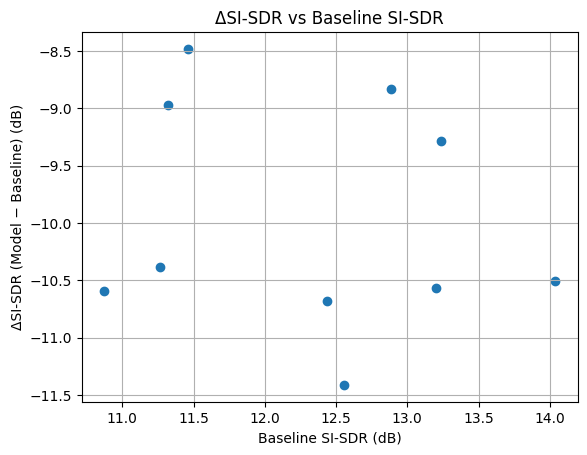

Saved: /content/exports/ddsp_vocals_residual_v1/delta_vs_baseline.png


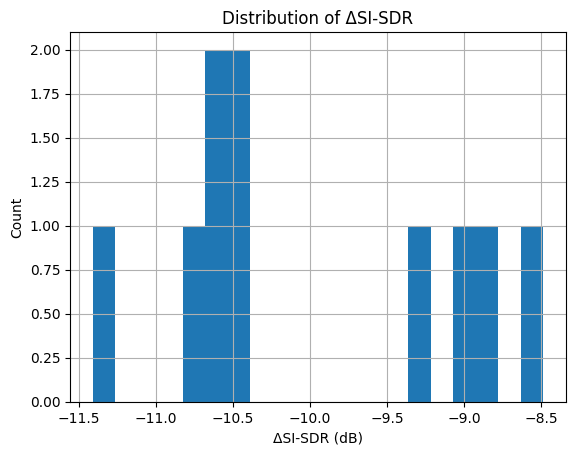

Saved: /content/exports/ddsp_vocals_residual_v1/delta_hist.png


In [27]:
# ====== 4) Diagnostic figures ======
import pandas as pd

df = pd.read_csv(CSV_PATH)

# A) ΔSI-SDR vs baseline SI-SDR
plt.figure()
plt.scatter(df["sdr_base"], df["delta_sdr"])
plt.xlabel("Baseline SI-SDR (dB)")
plt.ylabel("ΔSI-SDR (Model − Baseline) (dB)")
plt.title("ΔSI-SDR vs Baseline SI-SDR")
plt.grid(True)
fig1 = f"{EXPORT_DIR}/delta_vs_baseline.png"
plt.savefig(fig1, dpi=160, bbox_inches="tight")
plt.show()
print("Saved:", fig1)

# B) Histogram of ΔSI-SDR
plt.figure()
plt.hist(df["delta_sdr"], bins=20)
plt.xlabel("ΔSI-SDR (dB)")
plt.ylabel("Count")
plt.title("Distribution of ΔSI-SDR")
plt.grid(True)
fig2 = f"{EXPORT_DIR}/delta_hist.png"
plt.savefig(fig2, dpi=160, bbox_inches="tight")
plt.show()
print("Saved:", fig2)


In [28]:
# ====== OPTIONAL: write short A/B WAVs ======
import soundfile as sf

AUDIO_DIR = f"{EXPORT_DIR}/audio_ab"
os.makedirs(AUDIO_DIR, exist_ok=True)

def write_examples(val_ds, frozen_tracks, max_examples=12, seconds=4.0):
    needed = set(frozen_tracks[:max_examples])
    wrote = 0
    for cond, tgt in val_ds:
        x_in, f0_in, ld_db, mel_in, mel_gt, track, target = get_fields_from_example((cond, tgt))
        name = _decode_track_name(track)
        if name not in needed:
            continue

        y = _to_1d(target.numpy())
        xin = _to_1d(x_in.numpy())
        pred_in = {k: v for k, v in cond.items() if k in ("x_in","f0_in","loudness_db","mel_in","mel_gt","track")}
        yhat_pred = _to_1d(model(pred_in, training=False).numpy())
        yhat = xin + yhat_pred if PRED_IS_RESIDUAL and COMBINE_WITH_INPUT else yhat_pred

        # trim to fixed duration
        n = min(len(y), len(xin), len(yhat), int(seconds * SR))
        y, xin, yhat, yhat_pred = y[:n], xin[:n], yhat[:n], yhat_pred[:n]

        # write
        base = hashlib.md5(name.encode()).hexdigest()[:8]
        sf.write(f"{AUDIO_DIR}/{base}_input.wav", xin, SR)
        sf.write(f"{AUDIO_DIR}/{base}_model.wav", yhat, SR)
        if PRED_IS_RESIDUAL:
            sf.write(f"{AUDIO_DIR}/{base}_residual_pred.wav", yhat_pred, SR)
        wrote += 1
        needed.remove(name)
        if wrote >= max_examples:
            break
    print(f"Wrote {wrote} examples → {AUDIO_DIR}")

# Run (optional)
write_examples(val_run, FROZEN_TRACKS, max_examples=12, seconds=4.0)


Wrote 3 examples → /content/exports/ddsp_vocals_residual_v1/audio_ab


## Freeze

In [14]:
RUN_TAG   = "ddsp_vocals_residual_v1"
EXPORT_DIR = f"/content/exports/{RUN_TAG}"
SR         = 22050
N_EVAL     = 48  # how many val examples to score/export

import os, json, random, numpy as np, tensorflow as tf
os.makedirs(EXPORT_DIR, exist_ok=True)

cfg = dict(
    run_tag=RUN_TAG,
    sr=SR,
    n_eval=N_EVAL,
    model_params=int(sum(np.prod(v.shape) for v in model.trainable_variables)),
)
with open(os.path.join(EXPORT_DIR, "config.json"), "w") as f:
    json.dump(cfg, f, indent=2)
print(cfg)

{'run_tag': 'ddsp_vocals_residual_v1', 'sr': 22050, 'n_eval': 48, 'model_params': 41761}


In [15]:
#@title Metrics Helpers
import numpy as np
import tensorflow as tf

def si_sdr(ref, est):
    ref = ref.astype(np.float64) - np.mean(ref)
    est = est.astype(np.float64) - np.mean(est)
    den = np.dot(ref, ref) + 1e-12
    a   = np.dot(est, ref) / den
    e_true = a * ref
    e_res  = est - e_true
    return 10.0*np.log10((np.sum(e_true**2)+1e-12)/(np.sum(e_res**2)+1e-12))

def spec_conv(a, b, n_fft=1024, hop=256):
    A = np.abs(tf.signal.stft(a, n_fft, hop, n_fft).numpy())
    B = np.abs(tf.signal.stft(b, n_fft, hop, n_fft).numpy())
    return np.linalg.norm(A - B) / (np.linalg.norm(A) + 1e-12)

def np1d(t):
    x = t.numpy()
    return np.asarray(x).reshape(-1)

def voiced_pct(f0):
    return float(np.mean((np.asarray(f0).reshape(-1) > 0.0))) * 100.0


In [16]:
#@title Evaluation
import csv, math, os
from scipy.io import wavfile
from IPython.display import Audio, display

csv_path = os.path.join(EXPORT_DIR, "eval_summary.csv")
fields = ["idx","track","voiced_pct","rms_in","rms_pred","rms_tgt",
          "si_sdr_baseline","si_sdr_model","spec_conv_baseline","spec_conv_model",
          "len_samples"]

rows = []
sdrs_model, scs_model = [], []
sdrs_base,  scs_base  = [], []

it = iter(val_run.take(N_EVAL))
for k in range(N_EVAL):
    try:
        cond, tgt = next(it)
    except StopIteration:
        break

    # forward
    pred = model({
        # "f0_hz":       cond["f0_in"],
        "loudness_db": cond["loudness_db"],
        "mel_in":      cond["mel_in"],
        "x_in":        cond["x_in"],
    }, training=False)

    # tensors -> numpy
    y   = np1d(tgt).astype(np.float32)
    p   = np1d(pred).astype(np.float32)
    xin = np1d(cond["x_in"][:, :tf.shape(pred)[1]]).astype(np.float32)

    # residual output
    yhat =p

    # align
    n = min(len(y), len(yhat), len(xin))
    y, yhat, xin = y[:n], yhat[:n], xin[:n]

    # metrics
    sdr_b = si_sdr(y, xin)
    sdr_m = si_sdr(y, yhat)
    sc_b  = spec_conv(y, xin)
    sc_m  = spec_conv(y, yhat)

    sdrs_base.append(sdr_b);   sdrs_model.append(sdr_m)
    scs_base.append(sc_b);     scs_model.append(sc_m)

    # exports
    trk = cond["track"].numpy()[0].decode("utf-8") if "track" in cond else f"val_{k}"
    stem = f"{k:03d}_{trk.replace(' ','_')[:40]}"
    for tag, audio in [("input",xin),("pred",yhat),("target",y)]:
        wavfile.write(os.path.join(EXPORT_DIR, f"{stem}_{tag}.wav"), SR,
                      np.clip(audio, -1.0, 1.0))

    rows.append(dict(
        idx=k, track=trk, voiced_pct=voiced_pct(cond["f0_in"]),
        rms_in=float(np.sqrt(np.mean(xin*xin))+1e-12),
        rms_pred=float(np.sqrt(np.mean(yhat*yhat))+1e-12),
        rms_tgt=float(np.sqrt(np.mean(y*y))+1e-12),
        si_sdr_baseline=float(sdr_b), si_sdr_model=float(sdr_m),
        spec_conv_baseline=float(sc_b), spec_conv_model=float(sc_m),
        len_samples=int(n),
    ))

with open(csv_path, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=fields)
    w.writeheader(); w.writerows(rows)

print(f"wrote {len(rows)} rows → {csv_path}")
print(f"Median SI-SDR baseline: {np.median(sdrs_base):.2f} dB")
print(f"Median SI-SDR model:    {np.median(sdrs_model):.2f} dB")
print(f"Median SpecConv base:   {np.median(scs_base):.3f}")
print(f"Median SpecConv model:  {np.median(scs_model):.3f}")

# listen to one triplet
if rows:
    ex = rows[min(3, len(rows)-1)]
    base = os.path.join(EXPORT_DIR, f"{ex['idx']:03d}_{ex['track'].replace(' ','_')[:40]}")
    print("Preview:", ex['track'])
    display(Audio(os.path.join(EXPORT_DIR, base + "_input.wav"),  rate=SR))
    display(Audio(os.path.join(EXPORT_DIR, base + "_pred.wav"),   rate=SR))
    display(Audio(os.path.join(EXPORT_DIR, base + "_target.wav"), rate=SR))


KeyboardInterrupt: 

In [ ]:
#@title Quick Ablation
def eval_with_overrides(n_eval=16, drop_mel=False, drop_f0=False):
    sdrs = []
    for k, (cond, tgt) in enumerate(val_run.take(n_eval)):
        feed = {
            # "f0_hz":       (tf.zeros_like(cond["f0_in"]) if drop_f0 else cond["f0_in"]),
            "loudness_db": cond["loudness_db"],
            "mel_in":      (tf.zeros_like(cond["mel_in"]) if drop_mel else cond["mel_in"]),
            "x_in":        cond["x_in"],
        }
        pred = model(feed, training=False)
        y = np1d(tgt).astype(np.float32)
        p = np1d(pred).astype(np.float32)
        xin = np1d(cond["x_in"][:, :tf.shape(pred)[1]]).astype(np.float32)
        yhat = (p)[:min(len(y), len(p), len(xin))]
        y    = y[:len(yhat)]
        sdrs.append(si_sdr(y, yhat))
    return float(np.median(sdrs)) if sdrs else float("nan")

print("Median SI-SDR (eval, normal):", eval_with_overrides(24, False, False))
print("Median SI-SDR (no mel):      ", eval_with_overrides(24, True,  False))
